# **TikTok Project**

# **Classifying videos using machine learning**

**The purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

**The goal** is to build a model that predicts whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations

**Part 2:** Feature engineering

**Part 3:** Models Building & Evaluation

### Ethical considerations 

Lets consider the following questions:

1. **What are you being asked to do?**


2.   **What are the ethical implications of the model? What are the consequences of our model making errors?**
      *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

      *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?

**response:**

**1. What are you being asked to do?**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.

**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim



**2. What are the ethical implications of building the model?**

In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


### **Imports and data loading**

In [55]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import os
import pickle

In [35]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

In [36]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


**Note:**

From our previous phases we know:

* data has some missing values
* data has no duplicates
* Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.
* There are ouliers in our data

we know that **Tree-based** models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

In [37]:
# dropping missing values
data.dropna(inplace=True)

### **Feature engineering**

Create `text_length` column

In [38]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Lets' calculate the average `text_length` for claims and opinions.

In [39]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Lets visualize the distribution of `text_length` for claims and opinions using a histogram.

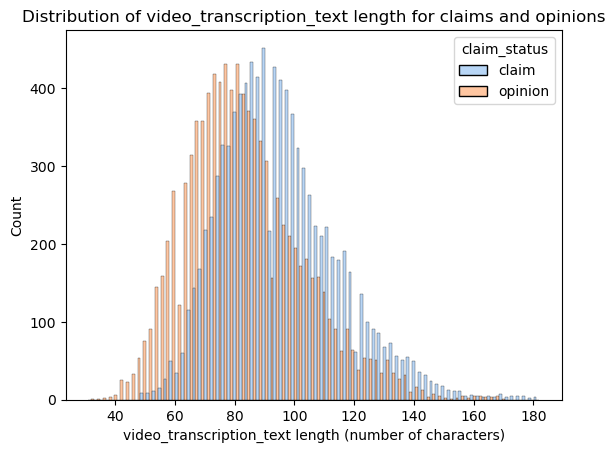

In [40]:
# Visualize the distribution of `text_length` for claims and opinions
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

**Note:**

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Encoding target and catgorical variables.

In [41]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Split data**

In [42]:
# Isolate target variable
y = X['claim_status']

# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
# Check shape of each training, validation, and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15267, 11), (3817, 11), (15267,), (3817,))

### **Tokenizing text column**

we will break each video's transcription text into both 2-grams and 3-grams, then take the 15 most frequently occurring tokens from the entire dataset to use as features.

In [45]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Fit the vectorizer to the training data

In [46]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
# Concat X_train, count_df to form the final training dataframe
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,37,743307.0,245805.0,66204.0,2226.0,237.0,85,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,7,198806.0,9374.0,338.0,187.0,30.0,96,False,False,False,...,1,0,0,0,0,0,0,0,0,0
2,21,60649.0,35453.0,12393.0,541.0,142.0,89,False,False,True,...,0,0,0,0,0,0,0,0,0,0
3,52,86.0,20.0,2.0,0.0,0.0,93,True,False,False,...,0,0,0,0,0,0,0,0,0,0
4,45,7930.0,2696.0,248.0,3.0,0.0,92,False,False,False,...,0,0,0,0,0,0,0,0,0,0


we will repeat the process to get n-gram counts for the test data.

In [49]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Store in in a df
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate X_test and test_count_df to form the final dataframe for testing data
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


### **Models Building**

### **Building a random forest model**


In [50]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': ['auto', 'sqrt', 'log2',
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [51]:
%%time
rf.fit(X_train_final, y_train)

CPU times: user 7min 25s, sys: 685 ms, total: 7min 26s
Wall time: 7min 26s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

#### Save random forest model

In [56]:
# Define a path to the folder where you want to save the model
path = os.getcwd() + "/"

In [57]:
def write_pickle(path, model_object, save_name):
    """save_name is a string."""
    with open(path + save_name + '.pickle', 'wb') as f:
        pickle.dump(model_object, f)

In [58]:
def read_pickle(path, saved_model_name):
    """saved_model_name is a string."""
    with open(path + saved_model_name + '.pickle', 'rb') as f:
        model = pickle.load(f)

        return model

In [59]:
# write model to file
write_pickle(path, rf, "rf_model")

In [60]:
# read model from file
rf = read_pickle(path, "rf_model")

In [61]:
# Examine best recall score
rf.best_score_

0.9955953512268343

In [62]:
# Examine best parameters
rf.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

### **Build an XGBoost model**

In [69]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [200, 300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [70]:
%%time
xgb.fit(X_train_final, y_train)

CPU times: user 17min 39s, sys: 3.14 s, total: 17min 42s
Wall time: 9min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [200, 300, 500]},
             refit='recall', scoring={'f1', 'accuracy', 'recall', 'precision'})

#### Save XGB Boost model

In [71]:
# write model to file
write_pickle(path, rf, "xgb_model")

In [72]:
# read model from file
xgb = read_pickle(path, "xgb_model")

In [73]:
xgb.best_score_

0.990543118009127

In [74]:
xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 200}

### **Evaluate models**

Evaluate models against test data.


#### **Random forest**

In [75]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf.best_estimator_.predict(X_test_final)

In [76]:
# Display the actual vs prediction
pd.DataFrame({"Actual": y_test, "Prediction": y_pred})

,Actual,Prediction
3695,1,1
11495,0,0
7604,1,1
12728,0,0
875,1,1
...,...,...
5488,1,1
10842,0,0
16253,0,0
1933,1,1


Creating a confusion matrix to visualize the results of the classification model.

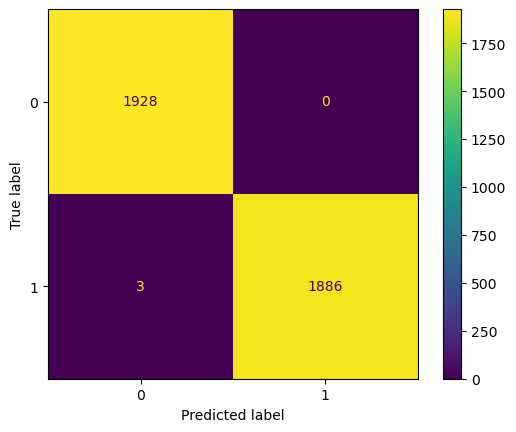

In [78]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

**Notes:**

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.
<br> </br>

In [80]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Note:**

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 3 misclassifications &mdash; 3 false negatives.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [81]:
#Evaluate XGBoost model
y_pred = xgb.best_estimator_.predict(X_test_final)

In [82]:
# Display the actual vs prediction
pd.DataFrame({"Actual": y_test, "Prediction": y_pred})

,Actual,Prediction
3695,1,1
11495,0,0
7604,1,1
12728,0,0
875,1,1
...,...,...
5488,1,1
10842,0,0
16253,0,0
1933,1,1


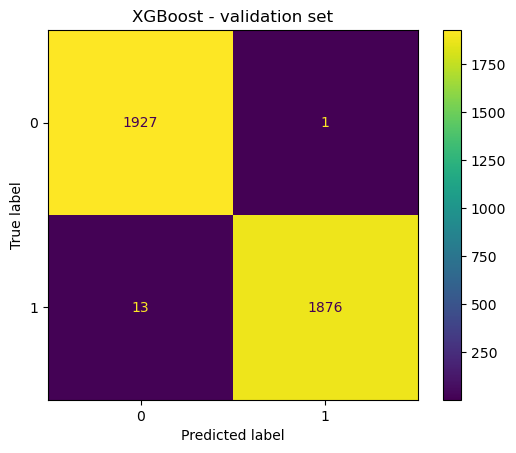

In [83]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [46]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Note:**

The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

#### **Feature importances of champion model**



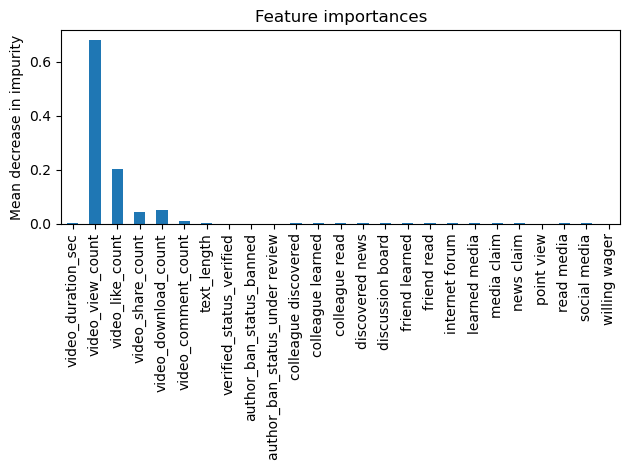

In [85]:
importances = rf.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Note:**

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

### **Conclusion**

Lets Consider the following questions:

1. **Would we recommend using this model? Why or why not?**

2. **What was our model doing? Can we explain how it was making predictions?**

3. **Are there new features that we can engineer that might improve model performance?**

4. **What features would we want to have that would likely improve the performance of your model?**

**response:**

1. *Would we recommend using this model? Why or why not?*

Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>

2. *What was our model doing? Can we explain how it was making predictions?*

The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>

3. *Are there new features that we can engineer that might improve model performance?*

Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>

4. *What features would we want to have that would likely improve the performance of your model?*

The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.

## Summary

Share an executive summary with my team [link](https://github.com/yousefayman2003/Portfolio-Projects/tree/main/Data-Science/TikTok/machine_learning/executive_summary.pdf)